In [1]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import pandas as pd
import sklearn 
import seaborn as sns

In [2]:
def load_data(path):
    dtype = {"tripduration":"Int64", #Note that this accepts nan values
              "start station id":"Int64",
              "start station name":"category",
              "start station latitude":"Float64",
              "start station longitude":"Float64",
              "end station id":"Int64",
              "end station name":"category",
              "end station latitude":"Float64",
              "end station longitude":"Float64",
              "bikeid":"Int64",
              "usertype":"category",
              "birth year":"Int64",
              "gender":"category"}
    data = pd.read_csv(path,parse_dates=["starttime","stoptime"])
    data = data.astype(dtype,copy=False) #Because reading category dtypes does not work out of the box
    return data

In [3]:
def print_memory_usage(data):
    memory = data.memory_usage(index=True,deep=True).sum()
    print(f"The dataframe needs {memory/1e9:.3} GB of memory")

In [4]:
data_train = load_data("Data/Train.csv")
print_memory_usage(data_train)
data_train.dtypes

The dataframe needs 1.83 GB of memory


tripduration                        Int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    Int64
start station name               category
start station latitude            Float64
start station longitude           Float64
end station id                      Int64
end station name                 category
end station latitude              Float64
end station longitude             Float64
bikeid                              Int64
usertype                         category
birth year                          Int64
gender                           category
roundtrip                            bool
haversine distance                float64
weekday                             int64
holiday                              bool
business day                         bool
speed                             float64
summer                               bool
dtype: object

In [5]:
data_train.tail()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,roundtrip,haversine distance,weekday,holiday,business day,speed,summer
13984169,2055,2018-10-22 10:16:23.900,2018-10-22 10:16:23.900,508,W 46 St & 11 Ave,40.763414,-73.996674,2008,Little West St & 1 Pl,40.705693,...,Subscriber,1982,2,False,6633.870726,0,False,True,11.621379,True
13984170,1628,2018-09-28 14:07:05.698,2018-09-28 14:07:05.698,2010,Grand St & Greene St,40.721655,-74.002347,438,St Marks Pl & 1 Ave,40.727791,...,Customer,1982,1,False,1562.855632,4,False,True,3.455946,True
13984171,623,2018-08-15 18:22:07.553,2018-08-15 18:22:07.553,3319,14 St & 5 Ave,40.666287,-73.988951,3381,3 St & Hoyt St,40.677729,...,Subscriber,1986,2,False,1331.506786,2,False,True,7.694100,True
13984172,410,2018-10-06 22:43:28.404,2018-10-06 22:43:28.404,3329,Degraw St & Smith St,40.682915,-73.993182,3321,Clinton St & Union St,40.683116,...,Subscriber,1976,2,False,394.222246,5,False,False,3.461464,True
13984173,270,2018-10-17 18:23:31.633,2018-10-17 18:23:31.633,461,E 20 St & 2 Ave,40.735877,-73.98205,3632,E 12 St & Avenue B,40.728049,...,Customer,1998,1,False,911.660541,2,False,True,12.155474,True


## Exploratory Analysis

Lets see how unbalanced the classes are

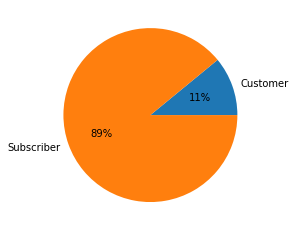

In [19]:
counts = data_train.groupby("usertype").size()
ax = counts.plot.pie(autopct='%1.0f%%',ylabel="")

### Distribution over month

Is this the same for each month?

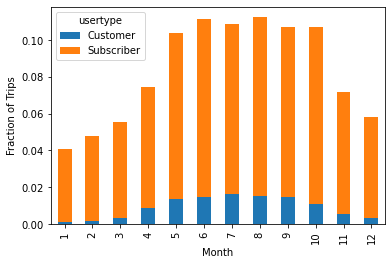

In [25]:
counts = data_train.groupby(by=["usertype",data_train["starttime"].dt.month]).size() / len(data_train)
counts = counts.unstack()
counts = counts.transpose()
ax = counts.plot.bar(stacked=True)
ax.set_xlabel("Month")
_ = ax.set_ylabel("Fraction of Trips")

We see that the amount of Customers varies more strongly with the month than the amount of subscribers.
This is easier to see by looking at the relative proportions of suscribers and customers for each month.

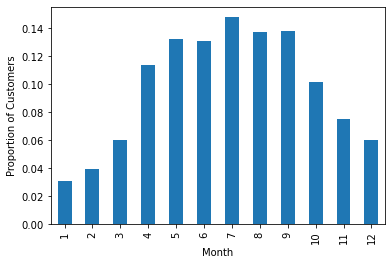

In [50]:
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Proportion of Customers",xlabel="Month",stacked=True)

### Holiday vs Business Day

Similarly, there are a lot more customers on weekends.

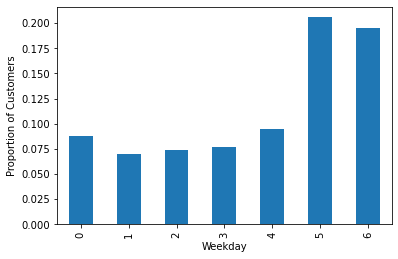

In [66]:
counts=data_train.groupby(["usertype","weekday"]).size() / len(data_train)
counts=counts.unstack().transpose()
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Proportion of Customers",xlabel="Weekday",stacked=True)

### Misc

In [16]:
sampled = data_train.sample(n=100000)
sampled["tripduration"] /= 60

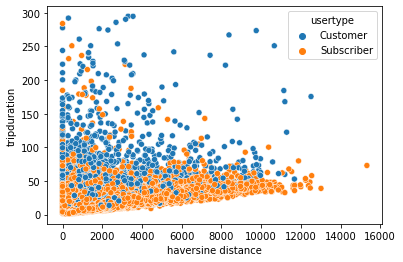

In [17]:
ax=sns.scatterplot(x="haversine distance",y="tripduration",data=sampled,hue="usertype")

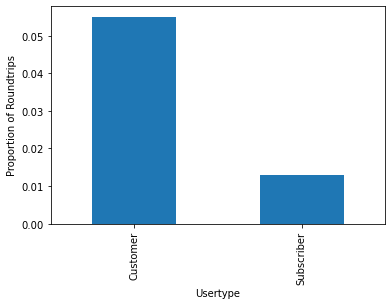

In [37]:
counts = data_train.groupby(["usertype", "roundtrip"]).size() / data_train.groupby("usertype").size()
counts=counts.unstack().transpose()
ax = counts.loc[True].plot.bar(ylabel="Proportion of Roundtrips",xlabel="Usertype")

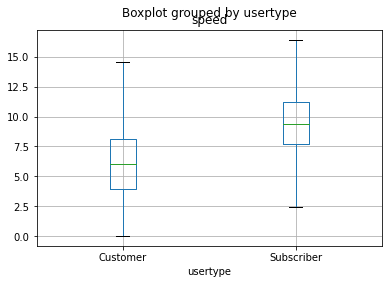

In [6]:
ax=data_train[data_train["roundtrip"]==False].boxplot("speed",by="usertype",showfliers=False)

### Gender

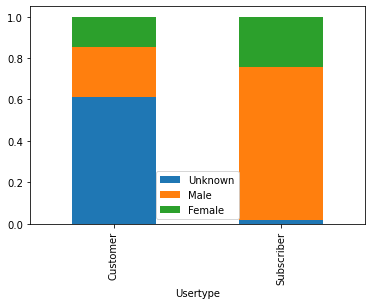

In [68]:
counts = data_train.groupby(["usertype","gender"]).size()
counts = counts/counts.groupby(level=0).sum() #Proportion in each group
counts=counts.unstack()
ax=counts.plot.bar(stacked=True,legend=["unknown","male","female"],xlabel="Usertype")
ax.legend(["Unknown","Male","Female"])